# Clean and feature extraction v5

## Clean text, extract stylometric, lexical and complexity features and create a new csv

## We are using `spacy`: The NLP *Ruby on Rails* 

[spacy](http://www.spacy.io/) is a library of natural language processing, robust, fast, easy to install and to use. It can be used with other NLP and Deep Learning Libraries.

With its pre-trained models in spanish language, we can operate the typical NLP jobs: Sentences segmentation, tokenization, POS tag, etc...

We are going to use the `es_core_news_lg` pre-trained model to make pos tagging:

### Also extracting headline features 

## V5 with syllabizer, avg_syllables, and readability spanish tests

In [1]:
import pandas as pd

In [7]:
df = pd.read_csv('../data/corpus_spanish_v3.csv', index_col = 0)

In [8]:
df.head()

,Category,Topic,Source,Headline,Text,Link
0,Fake,Society,actualidadpanamericana.com,Nueva sanción a Doña Gallina por discriminar g...,El pasado jueves 5 de noviembre la Superintend...,http://www.actualidadpanamericana.com/nueva-sa...
1,True,Education,abc,La RAE estudia incluir «machirulo» en el Dicci...,La RAE estudia incluir «machirulo» en el Dicci...,https://www.abc.es/cultura/abci-estudia-inclui...
2,True,Politics,Europa Press,Save the Children y ACNUR alertan de riesgos q...,El Alto Comisionado de Naciones Unidas para lo...,http://www.europapress.es/internacional/notici...
3,True,Society,Europa Press,Colegio de Abogados de Granada entrega distinc...,El Colegio de Abogados ha entregado en la maña...,http://www.europapress.es/sociedad/noticia-col...
4,Fake,Society,actualidadpanamericana.com,Espera de tres años a instalación de internet ...,Era todo un misterio el paradero de la familia...,http://www.actualidadpanamericana.com/espera-t...


In [9]:
df.shape

(3974, 6)

In [10]:
df.dtypes

Category    object
Topic       object
Source      object
Headline    object
Text        object
Link        object
dtype: object

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3974 entries, 0 to 3973
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  3974 non-null   object
 1   Topic     3974 non-null   object
 2   Source    3974 non-null   object
 3   Headline  3974 non-null   object
 4   Text      3974 non-null   object
 5   Link      3974 non-null   object
dtypes: object(6)
memory usage: 217.3+ KB


In [12]:
df.sample(5)

,Category,Topic,Source,Headline,Text,Link
39,Fake,Science,actualidadpanamericana.com,Madres que guardan celular en seno están produ...,"Aunque ya muchos lo sospechaban, hacía falta l...",http://www.actualidadpanamericana.com/madres-q...
3753,Fake,Science,actualidadpanamericana.com,Sentarse en el piso de los buses de TM produce...,Un estudio del centro de investigación en medi...,http://www.actualidadpanamericana.com/sentarse...
2905,Fake,Politics,actualidadpanamericana.com,"“Sin apoyo de Uldarico, imposible seguir diálo...",El ambiente de optimismo que reinaba en torno ...,http://www.actualidadpanamericana.com/sin-apoy...
1199,Fake,Economy,El Dizque,La Secretaría de Energía confirma que Disney c...,La Secretaría de Energía confirma que Disney c...,https://www.eldizque.com/la-secretaria-de-ener...
2918,Fake,Sport,actualidadpanamericana.com,Barra Barón rojo del América alista homenaje a...,Para el primer partido del América de Cali en ...,http://www.actualidadpanamericana.com/barra-ba...


## Apply it to the full corpus with iterrows()

In [13]:
# Tried several syllabizers for spanish and this is the chosen solution. Believe me, i spent a whole day.
# I had to replace all symbols, punctuations and it includes accentuation from other languages like ä, à, etc...
# It's a bit inconsistent with words from others languages, acronyms and abbreviations. However it performs really well

def get_nsyllables(text):
    from syltippy import syllabize

    text = text.replace(r"*NUMBER*", "número")
    text = text.replace(r"*PHONE*", "número")
    text = text.replace(r"*EMAIL*", "email")
    text = text.replace(r"*URL*", "url")
    text = re.sub(r'\d+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub(r'[^ \nA-Za-z0-9ÁÉÍÓÚÑáéíóúñ/]+', '', text)
    
    n_syllables = len(syllabize(text)[0])
    
    return n_syllables

In [14]:
%%time

import itertools
import pandas as pd
import nltk
import spacy
import re
from nltk import FreqDist
from sklearn.preprocessing import LabelEncoder
from lexical_diversity import lex_div as ld
pd.options.display.max_columns = None

nlp = spacy.load('es_core_news_lg')

df = pd.read_csv('../data/corpus_spanish_v3.csv')

labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Category'])

# empty lists and df
df_features = pd.DataFrame()
list_text = []
list_sentences = []
list_words = []
list_words_sent = []
list_word_size = []
list_avg_syllables_word = []
list_unique_words = []
list_ttr = []
list_mltd = []
list_entity_ratio = []
list_i_fernandez_huerta = []
list_i_szigriszt_pazos = []
list_ratio_uc_letters = []
list_nquotes = []
list_quotes_ratio = []
list_propn_ratio = [] 
list_noun_ratio = []
list_adp_ratio = []
list_det_ratio = []
list_punct_ratio = []
list_pron_ratio = []
list_verb_ratio = []
list_adv_ratio = []
list_sym_ratio = []

list_headline = []
list_words_h = []
list_word_size_h = []
list_avg_syllables_word_h = []
list_ttr_h = []
list_mltd_h = []
list_unique_words_h = []

# df iteration
for n, row in df.iterrows():
    
    ## headline ##
    headline = df['Headline'].iloc[n]
    headline = re.sub(r"http\S+", "", headline)
    headline = re.sub(r"http", "", headline)
    headline = re.sub(r"@\S+", "", headline)
    headline = re.sub("\n", " ", headline)
    headline = re.sub(r"(?<!\n)\n(?!\n)", " ", headline)
    headline = headline.replace(r"*NUMBER*", "número")
    headline = headline.replace(r"*PHONE*", "número")
    headline = headline.replace(r"*EMAIL*", "email")
    headline = headline.replace(r"*URL*", "url")
    headline_new = headline.lower()
    doc_h = nlp(headline_new)
    
    list_tokens_h = []
    list_tags_h = []
    n_sents_h = 0

    for sentence_h in doc_h.sents:
        n_sents_h += 1
        for token in sentence_h:
            list_tokens_h.append(token.text)

    fdist_h = FreqDist(list_tokens_h)
    n_syllables_h = get_nsyllables(headline)
    n_words_h = len(list_tokens_h)
    
    # headline complexity features
    avg_word_size_h = round(sum(len(word) for word in list_tokens_h) / n_words_h, 2)
    avg_syllables_word_h = round(n_syllables_h / n_words_h, 2)
    unique_words_h = round((len(fdist_h.hapaxes()) / n_words_h) * 100, 2)
    ttr_h = round(ld.ttr(list_tokens_h) * 100, 2)
    mltd_h = round(ld.mtld(list_tokens_h), 2)
    
    ## text content##   
    text = df['Text'].iloc[n]  
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"http", "", text)
    text = re.sub("\n", " ", text)
    text = text.replace(r"*NUMBER*", "número")
    text = text.replace(r"*PHONE*", "número")
    text = text.replace(r"*EMAIL*", "email")
    text = text.replace(r"*URL*", "url")
    
    # to later calculate upper case letters ratio
    alph = list(filter(str.isalpha, text))
    text_new = text.lower()
    doc = nlp(text)

    list_tokens = []
    list_pos = []
    list_tag = []
    list_entities = []
    n_sents = 0
    
    for entity in doc.ents:
        list_entities.append(entity.label_)

    for sentence in doc.sents:
        n_sents += 1
        for token in sentence:
            list_tokens.append(token.text)
            list_pos.append(token.pos_)
            list_tag.append(token.tag_)
    
    # Calculate entities, pos, tag, freq, syllables, wordsand quotes
    n_entities = len(list_entities)
    n_pos = nltk.Counter(list_pos)
    n_tag = nltk.Counter(list_tag)
    fdist = FreqDist(list_tokens)
    n_syllables = get_nsyllables(text)
    n_words = len(list_tokens)
    n_quotes = n_tag['PUNCT__PunctType=Quot']

    # complexity features
    avg_word_sentence = round(n_words / n_sents, 2)
    avg_word_size = round(sum(len(word) for word in list_tokens) / n_words, 2)
    avg_syllables_word = round(n_syllables / n_words, 2)
    unique_words = round((len(fdist.hapaxes()) / n_words) * 100, 2)
    ttr = round(ld.ttr(list_tokens) * 100, 2)
    mltd = round(ld.mtld(list_tokens), 2)

    # readability spanish test
    i_fernandez_huerta = round(206.84 - (60 * avg_syllables_word) - (1.02 * avg_word_sentence), 2)
    i_szigriszt_pazos = round(206.835 - ((62.3 * n_syllables) / n_words) - (n_words / n_sents), 2)

    # stylometric features
    ratio_uc_letters = round(sum(map(str.isupper, alph)) / len(alph) * 100, 2)
    entity_ratio = round((n_entities / n_words) * 100, 2)
    quotes_ratio = round((n_quotes / n_words) * 100, 2)
    propn_ratio = round((n_pos['PROPN'] / n_words) * 100 , 2)
    noun_ratio = round((n_pos['NOUN'] / n_words) * 100, 2) 
    adp_ratio = round((n_pos['ADP'] / n_words) * 100, 2)
    det_ratio = round((n_pos['DET'] / n_words) * 100, 2)
    punct_ratio = round((n_pos['PUNCT'] / n_words) * 100, 2)
    pron_ratio = round((n_pos['PRON'] / n_words) * 100, 2)
    verb_ratio = round((n_pos['VERB'] / n_words) * 100, 2)
    adv_ratio = round((n_pos['ADV'] / n_words) * 100, 2)
    sym_ratio = round((n_tag['SYM'] / n_words) * 100, 2)
    
    # appending on lists
    # headline
    list_headline.append(headline_new)
    list_words_h.append(n_words_h)
    list_word_size_h.append(avg_word_size_h)
    list_avg_syllables_word_h.append(avg_syllables_word_h)
    list_unique_words_h.append(unique_words_h)
    list_ttr_h.append(ttr_h)
    list_mltd_h.append(mltd_h)
    
    # text
    list_text.append(text_new)
    list_sentences.append(n_sents)
    list_words.append(n_words)
    list_words_sent.append(avg_word_sentence)
    list_word_size.append(avg_word_size)
    list_avg_syllables_word.append(avg_syllables_word)
    list_unique_words.append(unique_words)
    list_ttr.append(ttr)
    list_mltd.append(mltd)
    list_i_fernandez_huerta.append(i_fernandez_huerta)
    list_i_szigriszt_pazos.append(i_szigriszt_pazos)
    list_entity_ratio.append(entity_ratio)
    list_ratio_uc_letters.append(ratio_uc_letters)
    list_nquotes.append(n_quotes)
    list_quotes_ratio.append(quotes_ratio)
    list_propn_ratio.append(propn_ratio)
    list_noun_ratio.append(noun_ratio)
    list_adp_ratio.append(adp_ratio)
    list_det_ratio.append(det_ratio)
    list_punct_ratio.append(punct_ratio)
    list_pron_ratio.append(pron_ratio)
    list_verb_ratio.append(verb_ratio)
    list_adv_ratio.append(adv_ratio)
    list_sym_ratio.append(sym_ratio)
    
# dataframe
df_features['text'] = list_text
df_features['headline'] = list_headline

# headline
df_features['words_h'] = list_words_h
df_features['word_size_h'] = list_word_size_h
df_features['avg_syllables_word_h'] = list_avg_syllables_word_h
df_features['unique_words_h'] = list_unique_words_h
df_features['ttr_h'] = list_ttr_h
df_features['mltd_h'] = list_mltd_h

# text
df_features['sents'] = list_sentences
df_features['words'] = list_words
df_features['avg_words_sent'] = list_words_sent
df_features['avg_word_size'] = list_word_size
df_features['avg_syllables_word'] = list_avg_syllables_word
df_features['unique_words'] = list_unique_words
df_features['ttr'] = list_ttr
df_features['mltd'] = list_mltd
df_features['i_fernandez_huerta'] = list_i_fernandez_huerta
df_features['i_szigriszt_pazos'] = list_i_szigriszt_pazos
df_features['ratio_uc_letters'] = list_ratio_uc_letters
df_features['entity_ratio'] = list_entity_ratio
df_features['n_quotes'] = list_nquotes
df_features['quotes_ratio'] = list_quotes_ratio
df_features['propn_ratio'] = list_propn_ratio
df_features['noun_ratio'] = list_noun_ratio
df_features['adp_ratio'] = list_adp_ratio
df_features['det_ratio'] = list_det_ratio
df_features['punct_ratio'] = list_punct_ratio
df_features['pron_ratio'] = list_pron_ratio
df_features['verb_ratio'] = list_verb_ratio
df_features['adv_ratio'] = list_adv_ratio
df_features['sym_ratio'] = list_sym_ratio

df_features['label'] = df['Label']

df_features.to_csv('../data/spanish_corpus_features_v6.csv', encoding = 'utf-8', index = False)

CPU times: user 6min 10s, sys: 2.98 s, total: 6min 13s
Wall time: 6min 15s


In [15]:
df_features

,text,headline,words_h,word_size_h,avg_syllables_word_h,unique_words_h,ttr_h,mltd_h,sents,words,avg_words_sent,avg_word_size,avg_syllables_word,unique_words,ttr,mltd,i_fernandez_huerta,i_szigriszt_pazos,ratio_uc_letters,entity_ratio,n_quotes,quotes_ratio,propn_ratio,noun_ratio,adp_ratio,det_ratio,punct_ratio,pron_ratio,verb_ratio,adv_ratio,sym_ratio,label
0,el pasado jueves 5 de noviembre la superintend...,nueva sanción a doña gallina por discriminar g...,9,5.89,2.22,100.00,100.00,0.00,9,351,39.00,4.41,1.79,42.45,54.42,76.65,59.66,56.01,2.13,3.13,11,3.13,6.27,17.95,14.53,13.68,9.69,3.99,6.27,2.56,0.00,0
1,la rae estudia incluir «machirulo» en el dicci...,la rae estudia incluir «machirulo» en el dicci...,10,4.50,1.80,100.00,100.00,0.00,18,437,24.28,4.23,1.73,30.66,44.39,63.54,78.27,74.78,2.94,5.49,23,5.26,7.55,13.50,10.98,13.73,17.16,1.83,8.70,3.66,0.00,1
2,el alto comisionado de naciones unidas para lo...,save the children y acnur alertan de riesgos q...,16,4.62,1.81,87.50,93.75,71.68,27,1276,47.26,4.47,1.82,24.92,35.50,76.24,49.43,45.91,3.42,4.39,54,4.23,6.82,15.44,16.85,11.91,10.66,3.61,10.97,2.66,0.47,1
3,el colegio de abogados ha entregado en la maña...,colegio de abogados de granada entrega distinc...,13,5.00,2.23,76.92,84.62,23.66,10,587,58.70,4.39,1.85,28.79,40.89,55.69,35.97,32.87,4.42,8.01,16,2.73,16.35,15.67,17.55,13.29,10.39,2.21,7.67,0.85,0.00,1
4,era todo un misterio el paradero de la familia...,espera de tres años a instalación de internet ...,14,4.43,2.00,64.29,78.57,18.29,15,424,28.27,4.16,1.73,41.27,53.54,83.89,74.20,70.57,1.76,3.54,11,2.59,4.01,16.04,13.68,14.15,12.97,4.48,10.14,4.72,0.24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3969,qué creen? acabo de descubrir que los administ...,twitter apoya a amlo,4,4.25,2.00,100.00,100.00,0.00,6,83,13.83,4.27,1.63,66.27,74.70,65.39,94.93,91.67,5.09,8.43,0,0.00,14.46,6.02,9.64,3.61,19.28,4.82,9.64,3.61,0.00,0
3970,ver todos europa press nueva york.- el grupo c...,el grupo chino hna compra el 25% del gigante h...,15,5.33,1.93,86.67,93.33,63.00,15,572,38.13,4.69,1.81,33.57,46.15,70.47,59.35,55.86,5.11,9.44,3,0.52,15.21,19.58,17.48,10.84,9.44,1.22,6.47,1.75,0.00,1
3971,un curandero infecta de sida a medio centenar ...,un curandero infecta de sida a medio centenar ...,12,4.67,2.00,83.33,91.67,40.32,10,367,36.70,4.46,1.85,36.78,49.86,67.32,58.41,54.87,4.45,6.81,6,1.63,11.72,21.53,20.71,14.17,10.08,0.82,6.81,1.91,0.00,1
3972,política primeras páginas de los diarios llega...,primeras páginas de los diarios llegados esta ...,11,5.55,2.09,100.00,100.00,0.00,12,591,49.25,3.97,1.54,23.69,38.07,70.94,64.20,61.55,9.02,10.66,62,10.49,11.68,15.23,13.71,15.74,22.00,1.02,8.12,1.86,2.03,1


## Data visualization of features

In [70]:
df_features.columns

Index(['text', 'headline', 'words_h', 'word_size_h', 'avg_syllables_word_h',
       'unique_words_h', 'ttr_h', 'mltd_h', 'sents', 'words', 'avg_words_sent',
       'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd',
       'i_fernandez_huerta', 'i_szigriszt_pazos', 'ratio_uc_letters',
       'entity_ratio', 'n_quotes', 'quotes_ratio', 'propn_ratio', 'noun_ratio',
       'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio',
       'adv_ratio', 'sym_ratio', 'label'],
      dtype='object')

<AxesSubplot:xlabel='features', ylabel='value'>

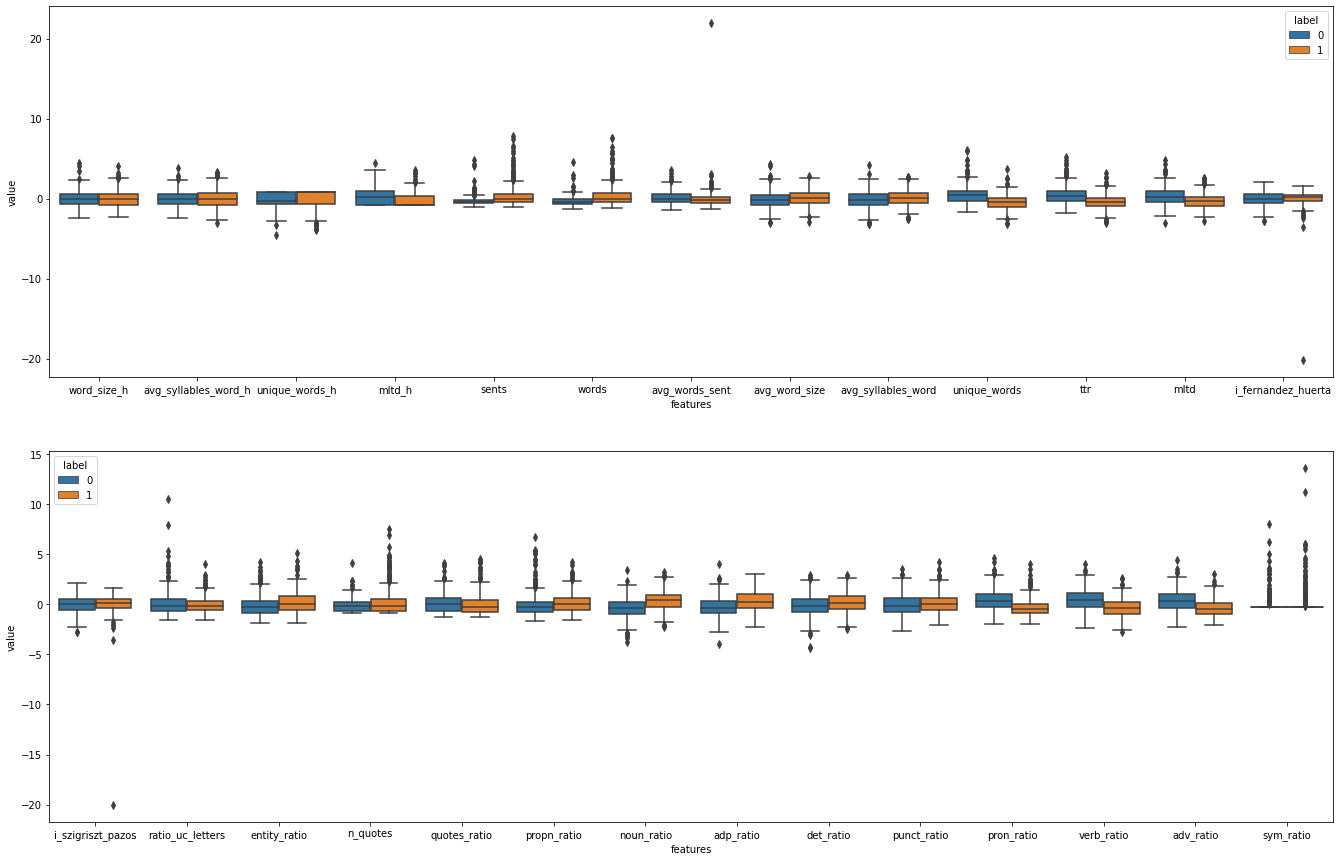

In [103]:
import seaborn as sns
from matplotlib import pyplot as plt

# All features don't fit well in 1 graphic so we divide it in 2 graphics

features1 = ['word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'mltd_h', 'sents', 'words',
             'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 'i_fernandez_huerta']

features2 = ['i_szigriszt_pazos', 'ratio_uc_letters', 'entity_ratio', 'n_quotes', 'quotes_ratio', 'propn_ratio', 'noun_ratio',
             'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 'adv_ratio', 'sym_ratio']

y = df_features['label']
x1 = df_features[features1]
x2 = df_features[features2]

# standarization
x1_st = (x1 - x1.mean()) / (x1.std())
x2_st = (x2 - x2.mean()) / (x2.std())

data1 = pd.concat([y, x1_st.iloc[:,]], axis = 1)
data1 = pd.melt(data1, id_vars = "label", var_name = "features", value_name = 'value')

data2 = pd.concat([y, x2_st.iloc[:,]], axis = 1)
data2 = pd.melt(data2, id_vars = "label", var_name = "features", value_name = 'value')

f, axs = plt.subplots(2, figsize = (23, 15))

sns.boxplot(x = "features", y = "value", hue = "label", data = data1, ax = axs[0])
sns.boxplot(x = "features", y = "value", hue = "label", data = data2, ax = axs[1])

In [13]:
import pandas as pd

df_features = pd.read_csv('../data/spanish_corpus_features_v5.csv')

In [14]:
df = df_features[df_features['label'] == 1]
df

,text,headline,words_h,word_size_h,avg_syllables_word_h,unique_words_h,ttr_h,mltd_h,sents,words,avg_words_sent,avg_word_size,avg_syllables_word,unique_words,ttr,mltd,i_fernandez_huerta,i_szigriszt_pazos,ratio_uc_letters,entity_ratio,n_quotes,quotes_ratio,propn_ratio,noun_ratio,adp_ratio,det_ratio,punct_ratio,pron_ratio,verb_ratio,adv_ratio,sym_ratio,label
0,sofía castro y alejandro peña pretelini: una i...,sofía castro y alejandro peña pretelini: una i...,12,5.58,2.50,100.00,100.00,0.00,6,244,40.67,4.30,1.78,38.52,52.87,61.00,58.56,55.10,4.39,7.79,0,0.00,15.98,15.98,14.34,11.89,9.02,5.74,6.56,3.28,0.00,1
1,un paso más cerca de hacer los exámenes 'onlin...,un paso más cerca de hacer los exámenes 'online',11,3.64,1.55,81.82,90.91,33.88,9,462,51.33,4.42,1.79,35.71,47.40,46.51,47.08,44.25,7.23,11.04,4,0.87,18.83,15.80,12.99,11.47,18.83,1.30,3.46,1.73,1.30,1
2,esto es lo que los científicos realmente piens...,esto es lo que los científicos realmente piens...,12,4.83,1.67,83.33,91.67,40.32,30,956,31.87,4.91,1.95,28.97,41.42,88.49,57.33,53.69,1.60,2.93,39,4.08,5.02,18.51,14.33,13.08,11.82,2.62,10.46,4.81,0.21,1
3,inicia impresión de boletas para elección pres...,inicia impresión de boletas para elección pres...,7,6.86,2.71,100.00,100.00,0.00,10,347,34.70,4.97,2.02,25.65,40.92,54.60,50.25,46.28,2.66,5.19,4,1.15,7.49,23.92,19.31,16.14,9.80,2.88,7.78,0.29,0.00,1
4,a número día del mundial fifa.com sigue la cue...,a número día del mundial,5,4.00,1.80,100.00,100.00,0.00,4,117,29.25,4.85,2.00,53.85,64.96,55.90,57.01,52.99,4.50,9.40,0,0.00,13.68,17.95,19.66,15.38,6.84,3.42,4.27,1.71,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,irán amplía la ley del aborto al permitir inte...,irán amplía la ley del aborto al permitir inte...,13,5.38,2.15,84.62,92.31,47.32,17,652,38.35,4.47,1.87,27.91,41.87,73.50,55.52,52.10,1.33,3.53,4,0.61,2.91,20.71,17.64,15.64,7.52,3.22,9.51,3.22,0.00,1
960,amlo sí militaba en el pri durante elecciones ...,amlo sí militaba en el pri durante elecciones ...,10,4.70,2.10,100.00,100.00,0.00,41,942,22.98,4.33,1.77,24.10,35.56,73.66,77.20,73.35,6.58,11.04,21,2.23,16.99,14.12,16.56,11.57,13.27,2.65,7.22,3.40,0.00,1
961,mercancía anti-trump en walmart genera polémic...,mercancía anti-trump en walmart genera polémica,6,7.00,2.83,100.00,100.00,0.00,2,77,38.50,5.06,2.04,54.55,71.43,53.22,45.17,41.31,5.32,11.69,6,7.79,20.78,22.08,15.58,7.79,14.29,1.30,6.49,1.30,0.00,1
962,luis videgaray deja la secretaría de hacienda ...,luis videgaray deja la secretaría de hacienda,7,5.57,2.43,100.00,100.00,0.00,9,307,34.11,4.62,1.96,29.97,46.91,65.32,54.45,50.56,4.87,9.77,0,0.00,17.59,16.94,15.64,14.98,7.82,2.61,9.77,2.28,0.00,1


In [15]:
df.mean()

words_h                  11.213849
word_size_h               4.794094
avg_syllables_word_h      2.001792
unique_words_h           91.910163
ttr_h                    95.783075
mltd_h                   15.459145
sents                    16.794297
words                   536.195519
avg_words_sent           35.499613
avg_word_size             4.483829
avg_syllables_word        1.852994
unique_words             33.270978
ttr                      47.218656
mltd                     72.542790
i_fernandez_huerta       59.450794
i_szigriszt_pazos        55.887067
ratio_uc_letters          3.559022
entity_ratio              7.121059
n_quotes                  9.150713
quotes_ratio              1.652770
propn_ratio              10.102383
noun_ratio               18.269593
adp_ratio                16.238208
det_ratio                12.863320
punct_ratio              11.350815
pron_ratio                2.991100
verb_ratio                8.832974
adv_ratio                 2.949348
sym_ratio           